# Regulation
來看看``linear model``們regulation的效用，我們模擬一些``dataset``並直接用``linear regression``來看看``training`` 和 ``testing``的 ``mean square error``如何。
下面我們製造50個``feature``的資料。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()


rng = np.random.RandomState(4)
X = rng.normal(size=(1000, 50))
beta = rng.normal(size=50)
y = np.dot(X, beta) + 4 * rng.normal(size=1000)

/projects/sage/sage-6.10/local/lib/python2.7/site-packages/matplotlib-1.5.0-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


我們將資料量size從0掃到700,利用內建的``learning curve``來觀察training和testing的score

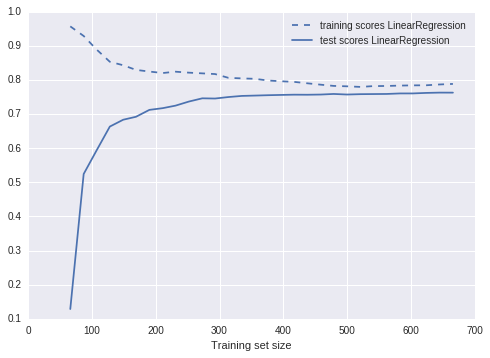

In [2]:
from sklearn import linear_model, cross_validation
from sklearn.learning_curve import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, train_sizes=np.linspace(.1, 1, 30))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.legend(loc='best')
    
plot_learning_curve(linear_model.LinearRegression(), X, y)

如圖所示，當training set size很小的時候，直接使用linear regression所得到的結果並不好。

Ridge regression的表現稍好些如下:

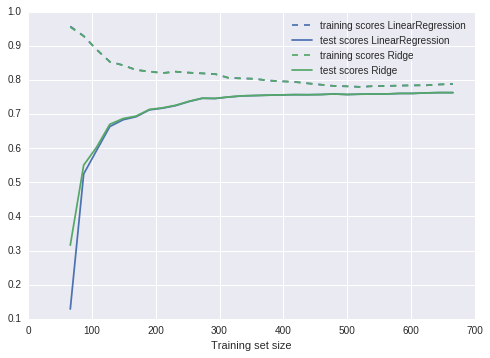

In [4]:
plot_learning_curve(linear_model.LinearRegression(), X, y)
plot_learning_curve(linear_model.Ridge(), X, y)

來看看``Lasso``吧，為了看出``Lasso``的效果，我們將實際的weight減少到10個

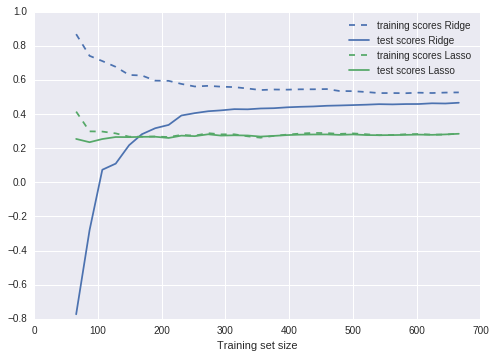

In [5]:
beta[10:] = 0
y = np.dot(X, beta) + 4*rng.normal(size=1000)
plot_learning_curve(linear_model.Ridge(), X, y)
plot_learning_curve(linear_model.Lasso(), X, y)

可以看出當實際data少時，``Lasso``篩選變數效果不錯，不過當data增加的時候，``Lasso``因為bias的關係而沒有表現很好

## Validation and Model Selection

In [1]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Validating Models
Machine learning中很重要的一塊就是參數選擇，我們從簡單的classifier開始

In [7]:
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
digits = load_digits()
X = digits.data
y = digits.target
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [8]:
y_pred = knn.predict(X)
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


上面我們test和train的data都用同一組，因此很容易發生overfit，比較好的方式是用validation的概念。

In [9]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

In [10]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

444 / 450 correct


用預設的validation方法得出正確率如上，用內建的score來檢驗看看

In [11]:
knn.score(X_test, y_test)

0.98666666666666669

挑參數時間

In [12]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.986666666667
5 0.982222222222
10 0.975555555556
20 0.966666666667
30 0.957777777778


In [20]:
from sklearn.neighbors import KNeighborsClassifierCV
knn = KNeighborsClassifierCV()
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

ImportError: cannot import name KNeighborsClassifierCV

## Cross Validation
用2-fold的CV來試看看

In [13]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((898, 64), (899, 64))

In [14]:
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.983296213808
0.982202447164


若k選擇較大的時候可用下列的方法

In [15]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)
cv.mean()

0.97614938602520218

這個函數會幫我們做k-fold的cv後平均

In [16]:
cross_val_score(KNeighborsClassifier(1), X, y, cv=10)

array([ 0.93513514,  0.99453552,  0.97237569,  0.98888889,  0.96089385,
        0.98882682,  0.99441341,  0.98876404,  0.97175141,  0.96590909])